In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from collections import defaultdict
import math
import matplotlib.pyplot as plt
from bisect import bisect_left
import statsmodels.api as sm
import glob
import scipy
import itertools

From the paper:

"Because we are using relative fitness, the effect of each individual drug can be interpreted as a percent reduction in growth rate, so the null expectation for the combined effects of two non-interacting drugs would be the product of two percentages, corresponding to a multiplicative definition of no interaction."

so cases compared to control in terms of fold differences, multiplciative model.

In [2]:
Lozano_2021_data_dir = "/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/drug_data/Lozano-HuntelmanEtAl2021/Raw Data and Growth Rate/Interaction Calculation/Data/Data/output_29-Oct-2020_log data/publish data_log"
Lozano_2021 = pd.read_csv(f"{Lozano_2021_data_dir}/FOX.FUS.STR.DOX.TMP.csv_PublishData.csv", sep=",")
Lozano_2021 = Lozano_2021.loc[:, "combinations":"X1X2X3X4X5"]

files = glob.glob(Lozano_2021_data_dir + "/*.csv")
df = pd.DataFrame
for f in files:
    tmp = pd.read_csv(f, sep=",")
    tmp = tmp.loc[:, "combinations":"X1X2X3X4X5"]
    #tmp = tmp.tail(n=1)
    try:
        df = pd.concat([df, tmp], axis=0)
    except:
        df = tmp
#df.loc[:, "combinations"] = df.combinations.str.replace("3","_")
df = df.reset_index(drop=True)



In [96]:
df

,combinations,X1,X2,X3,X4,X5,X1X2,X1X3,X1X4,X1X5,...,X2X3X4,X2X3X5,X2X4X5,X3X4X5,X1X2X3X4,X1X2X3X5,X1X2X4X5,X1X3X4X5,X2X3X4X5,X1X2X3X4X5
0,AMP1FOX1FUS1CPR1ERY1,0.96503,0.99944,0.60245,1.0,1.00000,0.62984,0.47301,0.84633,0.97794,...,0.75448,0.28603,0.97847,0.61188,0.000000,0.45419,0.61188,0.66047,0.35611,0.42552
1,AMP1FOX1FUS1CPR1ERY2,0.96503,0.99944,0.60245,1.0,1.00000,0.62984,0.47301,0.84633,0.96402,...,0.75448,0.80682,0.96748,0.78905,0.000000,0.44888,0.62692,0.77261,0.82919,0.41342
2,AMP1FOX1FUS1CPR1ERY3,0.96503,0.99944,0.60245,1.0,1.00000,0.62984,0.47301,0.84633,0.96706,...,0.75448,0.58936,0.97794,0.73387,0.000000,0.53402,0.75830,0.58223,0.39821,0.35462
3,AMP1FOX1FUS1CPR2ERY1,0.96503,0.99944,0.60245,1.0,1.00000,0.62984,0.47301,0.94507,0.97794,...,0.46157,0.28603,0.96835,0.59269,0.064393,0.45419,0.76493,0.60528,0.65518,0.44123
4,AMP1FOX1FUS1CPR2ERY2,0.96503,0.99944,0.60245,1.0,1.00000,0.62984,0.47301,0.94507,0.96402,...,0.46157,0.80682,1.00000,0.57562,0.064393,0.44888,0.82457,0.81218,0.88719,0.25878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13603,AMP3CPR3ERY3FUS2TMP2,1.00000,1.00000,1.00000,1.0,0.86895,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.000000,1.00000,1.00000,1.00000,1.00000,1.00000
13604,AMP3CPR3ERY3FUS2TMP3,1.00000,1.00000,1.00000,1.0,0.80398,1.00000,1.00000,1.00000,0.76565,...,1.00000,0.84355,0.92333,0.93394,1.000000,0.74675,0.81935,0.50855,1.00000,0.85684
13605,AMP3CPR3ERY3FUS3TMP1,1.00000,1.00000,1.00000,1.0,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,0.96620,0.85254,1.000000,1.00000,0.90647,0.97399,0.94025,0.85426
13606,AMP3CPR3ERY3FUS3TMP2,1.00000,1.00000,1.00000,1.0,0.86895,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,0.93594,0.86485,1.000000,1.00000,0.82445,0.97767,0.89372,0.89213


In [3]:
df_sing = df.loc[:,"X1":"X5"].reset_index(drop=True)
df_doub = df.loc[:,"X1X2":"X4X5"].reset_index(drop=True)
df_trip = df.loc[:,"X1X2X3":"X3X4X5"].reset_index(drop=True)
df_quad = df.loc[:,"X1X2X3X4":"X2X3X4X5"].reset_index(drop=True)
df_quin = pd.DataFrame(df.loc[:,"X1X2X3X4X5"].reset_index(drop=True))
combinations = pd.DataFrame(df.loc[:,"combinations"].reset_index(drop=True))
# one of the columns has an extra whitespace
df_trip = df_trip.rename(columns={'X1X4X5 ' : 'X1X4X5'})


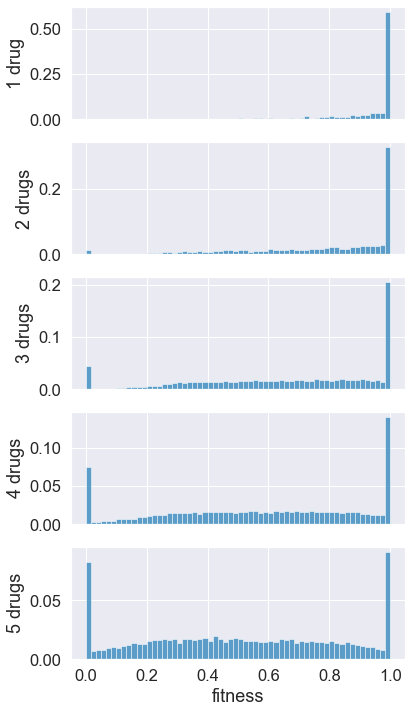

In [4]:
sns.set(font_scale = 1.5)
fig, axs = plt.subplots(nrows=5, figsize=(15,5))
fig.set_size_inches(6, 12)
bins=60

def concat_cols(df):
    x = []
    [x.extend(list(df[i])) for i in list(df.columns)]
    return x

def plot_fitness(df, title, index):
    sns.histplot(concat_cols(df),  color="#2b83ba", bins = bins, stat="probability", ax=axs[index])
    if index < 4:
        axs[index].set(xlabel=None, ylabel=title, xticklabels=[])
    else:
        axs[index].set(xlabel="fitness", ylabel=title)

sns.set_style("whitegrid")
plot_fitness(df_sing, "1 drug", 0)
plot_fitness(df_doub, "2 drugs", 1)
plot_fitness(df_trip, "3 drugs", 2)
plot_fitness(df_quad, "4 drugs", 3)
plot_fitness(df_quin, "5 drugs", 4)
#sns.despine()



In [5]:
def get_fitness_triple_interaction(df_sing, df_doub, df_trip, col):
    f = [col[i:i+2] for i in range(0, len(col), 2)]
    f_ijk = df_trip[col]
    f_i = df_sing[f[0]]
    f_j = df_sing[f[1]]
    f_k = df_sing[f[2]]
    f_ij = df_doub[f[0]+f[1]]
    f_ik = df_doub[f[0]+f[2]]
    f_jk = df_doub[f[1]+f[2]]
    return f_ijk, f_i, f_j, f_k, f_ij, f_ik, f_jk

def get_fitness_quadruple_interaction(df_sing, df_doub, df_trip, df_quad, col):
    fitnesses = defaultdict(pd.Series)

    f = [col[i:i+2] for i in range(0, len(col), 2)]

    fitnesses[1234] = df_quad[col]

    fitnesses[123] = df_trip[f[0]+f[1]+f[2]]
    fitnesses[124] = df_trip[f[0]+f[1]+f[3]]
    fitnesses[134] = df_trip[f[0]+f[2]+f[3]]
    fitnesses[234] = df_trip[f[1]+f[2]+f[3]]

    fitnesses[12] = df_doub[f[0]+f[1]]
    fitnesses[13] = df_doub[f[0]+f[2]]
    fitnesses[14] = df_doub[f[0]+f[3]]
    fitnesses[23] = df_doub[f[1]+f[2]]
    fitnesses[24] = df_doub[f[1]+f[3]]
    fitnesses[34] = df_doub[f[2]+f[3]]

    fitnesses[1] = df_sing[f[0]]
    fitnesses[2] = df_sing[f[1]]
    fitnesses[3] = df_sing[f[2]]
    fitnesses[4] = df_sing[f[3]]
    
    return fitnesses


def get_fitness_quintuple_interaction(df_sing, df_doub, df_trip, df_quad, df_quin, col):
    fitnesses = defaultdict(pd.Series)

    f = [col[i:i+2] for i in range(0, len(col), 2)]

    fitnesses[12345] = df_quin[col]

    fitnesses[1234] = df_quad[f[0]+f[1]+f[2]+f[3]]
    fitnesses[1235] = df_quad[f[0]+f[1]+f[2]+f[4]]
    fitnesses[1245] = df_quad[f[0]+f[1]+f[3]+f[4]]
    fitnesses[1345] = df_quad[f[0]+f[2]+f[3]+f[4]]
    fitnesses[2345] = df_quad[f[1]+f[2]+f[3]+f[4]]

    fitnesses[123] = df_trip[f[0]+f[1]+f[2]]
    fitnesses[124] = df_trip[f[0]+f[1]+f[3]]
    fitnesses[125] = df_trip[f[0]+f[1]+f[4]]
    fitnesses[134] = df_trip[f[0]+f[2]+f[3]]
    fitnesses[135] = df_trip[f[0]+f[2]+f[4]]
    fitnesses[145] = df_trip[f[0]+f[3]+f[4]]
    fitnesses[234] = df_trip[f[1]+f[2]+f[3]]
    fitnesses[235] = df_trip[f[1]+f[2]+f[4]]
    fitnesses[245] = df_trip[f[1]+f[3]+f[4]]
    fitnesses[345] = df_trip[f[2]+f[3]+f[4]]

    fitnesses[12] = df_doub[f[0]+f[1]]
    fitnesses[13] = df_doub[f[0]+f[2]]
    fitnesses[14] = df_doub[f[0]+f[3]]
    fitnesses[15] = df_doub[f[0]+f[4]]
    fitnesses[23] = df_doub[f[1]+f[2]]
    fitnesses[24] = df_doub[f[1]+f[3]]
    fitnesses[25] = df_doub[f[1]+f[4]]
    fitnesses[34] = df_doub[f[2]+f[3]]
    fitnesses[35] = df_doub[f[2]+f[4]]
    fitnesses[45] = df_doub[f[3]+f[4]]

    fitnesses[1] = df_sing[f[0]]
    fitnesses[2] = df_sing[f[1]]
    fitnesses[3] = df_sing[f[2]]
    fitnesses[4] = df_sing[f[3]]
    fitnesses[5] = df_sing[f[4]]

    return fitnesses

In [6]:


for col in df_doub.columns:
    f = [col[i:i+2] for i in range(0, len(col), 2)]
    #print(f_i)
    name = col + "_iss"
    df_doub.loc[:, name] = df_doub[col] - (df_sing[f[0]]*df_sing[f[1]])
    name = col + "_mult"
    df_doub.loc[:, name] = df_doub[col]/(df_sing[f[0]]*df_sing[f[1]])

for col in df_trip.columns:
    f_ijk, f_i, f_j, f_k, f_ij, f_ik, f_jk = get_fitness_triple_interaction(df_sing, df_doub, df_trip, col)
    name = col + "_iss"
    df_trip.loc[:, name] = f_ijk + 2*f_i*f_j*f_k - f_ij*f_k - f_ik*f_j - f_jk*f_i
    name = col + "_mult"
    df_trip.loc[:, name] = (f_ijk*f_i*f_j*f_k)/(f_ij*f_ik*f_jk)

for col in df_quad.columns:
    f = get_fitness_quadruple_interaction(df_sing, df_doub, df_trip, df_quad, col)
    name = col + "_iss"
    df_quad.loc[:, name] = f[1234] - f[1]*f[234] - f[2]*f[134] - f[3]*f[124] - f[4]*f[123] - f[12]*f[34] - f[13]*f[24] - f[14]*f[23] + (2*f[1]*f[2]*f[34]) + (2*f[1]*f[3]*f[24]) + (2*f[1]*f[4]*f[23]) + (2*f[2]*f[3]*f[14]) + (2*f[2]*f[4]*f[13]) + (2*f[3]*f[4]*f[12]) - (6*f[1]*f[2]*f[3]*f[4])
    name = col + "_mult"
    df_quad.loc[:, name] = (f[1234]*f[12]*f[13]*f[14]*f[23]*f[24]*f[34])/(f[1]*f[2]*f[3]*f[4]*f[123]*f[124]*f[134]*f[234])


for col in df_quin.columns:
    f = get_fitness_quintuple_interaction(df_sing, df_doub, df_trip, df_quad, df_quin, col)
    name = col + "_iss"
    # 52 terms
    df_quin.loc[:, name] = f[12345] - 1*f[1]*f[2345] - f[2]*f[1345] - f[3]*f[1245] - f[4]*f[1235] - f[5]*f[1234] - 1*f[12]*f[345] - f[13]*f[245] - f[14]*f[235] - f[15]*f[234] - f[23]*f[145] - f[24]*f[135] - f[25]*f[134] - f[34]*f[125] - f[35]*f[124] - f[45]*f[123] + 2*f[1]*f[2]*f[345] + 2*f[1]*f[3]*f[245] + 2*f[1]*f[4]*f[235] + 2*f[1]*f[5]*f[234] + 2*f[2]*f[3]*f[145] + 2*f[2]*f[4]*f[135] + 2*f[2]*f[5]*f[134] + 2*f[3]*f[4]*f[125] + 2*f[3]*f[5]*f[124] + 2*f[4]*f[5]*f[123] + 2*f[12]*f[34]*f[5] + 2*f[12]*f[35]*f[4] + 2*f[12]*f[45]*f[3] + 2*f[13]*f[24]*f[5] + 2*f[13]*f[25]*f[4] + 2*f[13]*f[45]*f[2] + 2*f[14]*f[23]*f[5] + 2*f[14]*f[25]*f[3] + 2*f[14]*f[35]*f[2] + 2*f[15]*f[23]*f[4] + 2*f[15]*f[24]*f[3] + 2*f[15]*f[34]*f[2] + 2*f[23]*f[45]*f[1] + 2*f[24]*f[35]*f[1] + 2*f[25]*f[34]*f[1] - 6*f[12]*f[3]*f[4]*f[5] - 6*f[13]*f[2]*f[4]*f[5] - 6*f[14]*f[2]*f[3]*f[5] - 6*f[15]*f[2]*f[3]*f[4] - 6*f[23]*f[1]*f[4]*f[5] - 6*f[24]*f[1]*f[3]*f[5] - 6*f[25]*f[1]*f[3]*f[4] - 6*f[34]*f[1]*f[2]*f[5] - 6*f[35]*f[1]*f[2]*f[4] - 6*f[45]*f[1]*f[2]*f[3] + 24*f[1]*f[2]*f[3]*f[4]*f[5]
    #a = f[12345] 
    #b = -1*f[1]*f[2345] - f[2]*f[1345] - f[3]*f[1245] - f[4]*f[1235] - f[5]*f[1234]
    #c = -1*f[12]*f[345] - f[13]*f[245] - f[14]*f[235] - f[15]*f[234] - f[23]*f[145] - f[24]*f[135] - f[25]*f[134] - f[34]*f[125] - f[35]*f[124] - f[45]*f[123]
    #d = 2*f[1]*f[2]*f[345] + 2*f[1]*f[3]*f[245] + 2*f[1]*f[4]*f[235] + 2*f[1]*f[5]*f[234] + 2*f[2]*f[3]*f[145] + 2*f[2]*f[4]*f[135] + 2*f[2]*f[5]*f[134] + 2*f[3]*f[4]*f[125] + 2*f[3]*f[5]*f[124] + 2*f[4]*f[5]*f[123]
    #e = 2*f[12]*f[34]*f[5] + 2*f[12]*f[35]*f[4] + 2*f[12]*f[45]*f[3] + 2*f[13]*f[24]*f[5] + 2*f[13]*f[25]*f[4] + 2*f[13]*f[45]*f[2] + 2*f[14]*f[23]*f[5] + 2*f[14]*f[25]*f[3] + 2*f[14]*f[35]*f[2] + 2*f[15]*f[23]*f[4] + 2*f[15]*f[24]*f[3] + 2*f[15]*f[34]*f[2] + 2*f[23]*f[45]*f[1] + 2*f[24]*f[35]*f[1] + 2*f[25]*f[34]*f[1]
    #f = -6*f[12]*f[3]*f[4]*f[5] - 6*f[13]*f[2]*f[4]*f[5] - 6*f[14]*f[2]*f[3]*f[5] - 6*f[15]*f[2]*f[3]*f[4] - 6*f[23]*f[1]*f[4]*f[5] - 6*f[24]*f[1]*f[3]*f[5] - 6*f[25]*f[1]*f[3]*f[4] - 6*f[34]*f[1]*f[2]*f[5] - 6*f[35]*f[1]*f[2]*f[4] - 6*f[45]*f[1]*f[2]*f[3]
    #g = 24*f[1]*f[2]*f[3]*f[4]*f[5]
    #df_quin.loc[:, name] = a + b + c + d + e + f + g
    name = col + "_mult"
    df_quin.loc[:, name] = (f[12345]*f[1]*f[2]*f[3]*f[4]*f[5]*f[123]*f[124]*f[125]*f[134]*f[135]*f[145]*f[234]*f[235]*f[245]*f[345])/(f[12]*f[13]*f[14]*f[15]*f[23]*f[24]*f[25]*f[34]*f[35]*f[45]*f[1234]*f[1235]*f[1245]*f[1345]*f[2345])


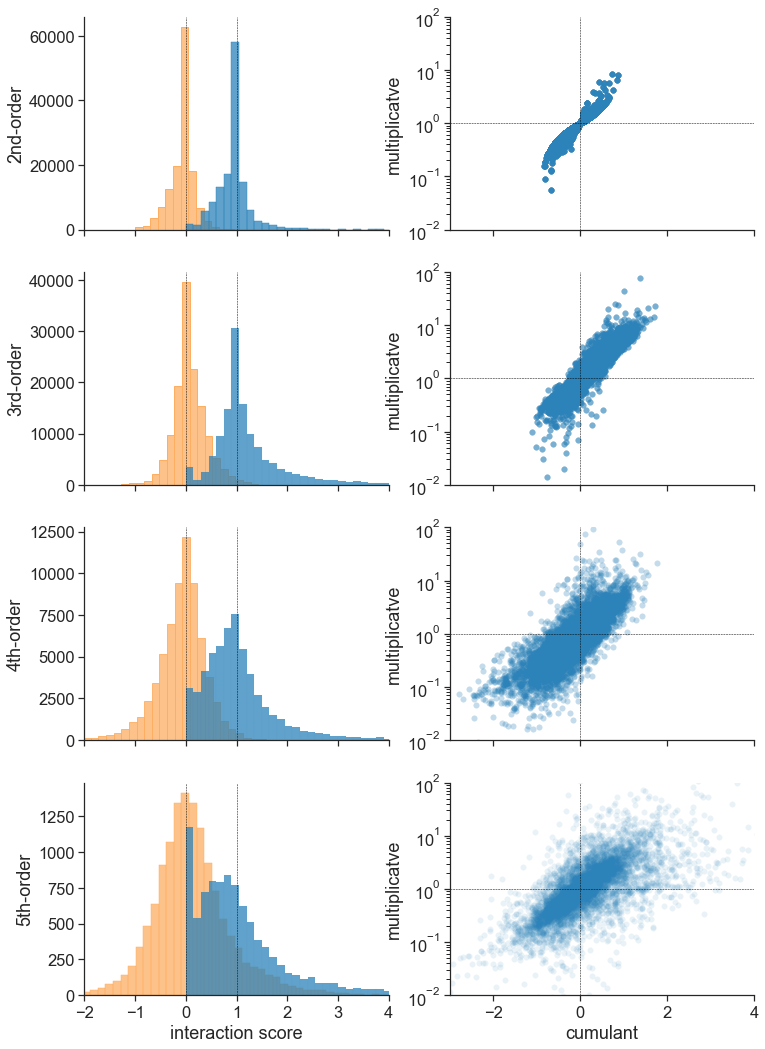

In [95]:
def get_noninfzero(df):
    x = np.array(concat_cols(df.filter(regex=(".*_iss"))))
    y = np.array(concat_cols(df.filter(regex=(".*_mult"))))
    x = x[~np.isnan(y) & np.isfinite(y) & (y > 0)]
    y = y[~np.isnan(y) & np.isfinite(y) & (y > 0)]
    return x, y

def mk_histplot(df, pl, title, row):
    sns.histplot(concat_cols(df.filter(regex=(".*_iss"))), binwidth=pl['binwid'], color=pl['col_iss'], edgecolor=pl['edgecol_iss'], ax=axs[row,0])
    sns.histplot(concat_cols(df.filter(regex=(".*_mult"))), binwidth=pl['binwid'], color=pl['col_mult'], edgecolor=pl['edgecol_mult'], ax=axs[row,0])
    if row < 3:
        axs[row,0].set(xlabel=None, ylabel=title, xticklabels=[])
    else:
        axs[row,0].set(xlabel="interaction score", ylabel=title)
    axs[row,0].set_xlim(-2,4)
    axs[row,0].axvline(0, color="black", linestyle="--", linewidth=0.5)
    axs[row,0].axvline(1, color="black", linestyle="--", linewidth=0.5)

    x, y = get_noninfzero(df)
    sns.scatterplot(x=x, 
                y=y,   
                alpha=pl['transparency'], color=pl['col_mult'], linewidth=0,
                ax=axs[row,1])
    if row < 3:
        axs[row,1].set(xlabel=None, ylabel="multiplicatve", xticklabels=[])
    else:
        axs[row,1].set(xlabel="cumulant", ylabel="multiplicatve")
    axs[row,1].axvline(0, color="black", linestyle="--", linewidth=0.5)
    axs[row,1].axhline(1, color="black", linestyle="--", linewidth=0.5)
    axs[row,1].set_ylim(0.01,100)
    axs[row,1].set_xlim(-3,4)
    axs[row,1].set_yscale('log')
    #axs[row,1].axline([0,1], [80, 81], linestyle="--", color="black")



sns.set(font_scale = 1.5)
sns.set_style("ticks")
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15,5))
fig.set_size_inches(12, 18)

for_plt = {}
for_plt['binwid'] = 0.15
for_plt['transparency']=0.1

# brown and green
#col_iss = "#018571"
#col_mult = "#a6611a"
#edgecol_iss = "#018571"
#edgecol_mult = "#a6611a"

# yellow and blue
#col_iss = "#ffff99"
#col_mult = "#386cb0"
#edgecol_iss = "black"
#edgecol_mult = "#386cb0"

# blue and
for_plt['col_iss'] = "#fdae61"
for_plt['col_mult'] = "#2b83ba"
for_plt['edgecol_iss'] = "#fdae61"
for_plt['edgecol_mult'] = "#2b83ba"

##################
mk_histplot(df_doub, for_plt, "2nd-order", 0)
mk_histplot(df_trip, for_plt, "3rd-order", 1)
mk_histplot(df_quad, for_plt, "4th-order", 2)
mk_histplot(df_quin, for_plt, "5th-order", 3)

sns.despine()


before filtering mult for 0's, nan, inf:  13608
after filtering mult for 0's, nan, inf:  8885
rank_diff_upper_outliers:  4411.799999999996
rank_diff_lower_outliers:  51.0


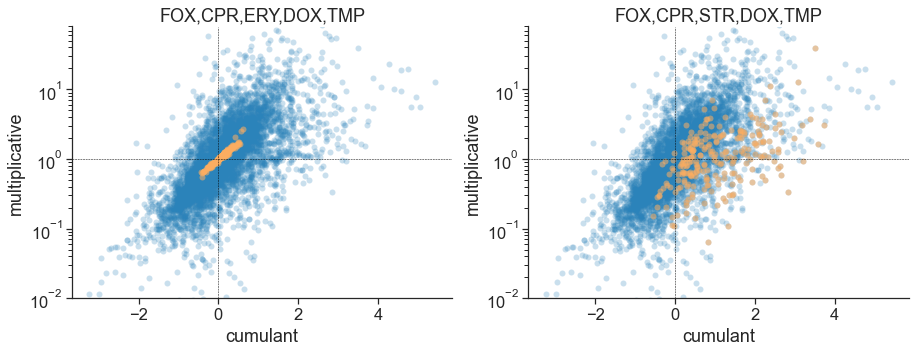

In [85]:
# find drug combinations that have the largest differences b/t multiplicative and cumulant scales

def gather_combos_into_single_column(df, suff):
    x = pd.concat([combinations, df.filter(regex=(f".*{suff}"))], axis=1)
    cols = [i for i in x.columns if suff in i]
    x = x.melt(id_vars="combinations", value_vars=cols)
    x.variable = x.variable.str.replace(suff,"")
    return x.rename(columns={"value":suff.replace("_","")})

# for interactions with order below 5, the data are scattered across many columns, e.g. X1X2X3 and X2X3X4 etc.
# for a specific scale (iss or mult), get all the columns and combine them into a single column
iss = gather_combos_into_single_column(df_quin, "_iss")
mult = gather_combos_into_single_column(df_quin, "_mult")

# combine all iss and mult data into a single data frame
im = iss.merge(mult, how="outer", on=["combinations", "variable"])
print("before filtering mult for 0's, nan, inf: ",len(im))
im = im[~np.isnan(im.mult) & np.isfinite(im.mult) & (im.mult > 0)].reset_index(drop=True)
print("after filtering mult for 0's, nan, inf: ",len(im))

# sort by iss and mult separately to get ranks, then compute the difference b/t ranks
im = im.sort_values(by="iss").reset_index(drop=True)
im.index.name = "iss_sort"
im = im.reset_index()
im = im.sort_values(by="mult").reset_index(drop=True)
im.index.name = "mult_sort"
im = im.reset_index()
im.loc[:,"rank_diff"] = abs(im['iss_sort'] - im['mult_sort'])

# get values (in terms of rank differences) that represent drug combinations that have the most and least different ranks
rank_diff_upper_outliers = np.quantile(im.rank_diff, 0.95)
rank_diff_lower_outliers = np.quantile(im.rank_diff, 0.05)

print("rank_diff_upper_outliers: ", rank_diff_upper_outliers)
print("rank_diff_lower_outliers: ", rank_diff_lower_outliers)

#lower_quant_mult = np.quantile(im.mult, 0.05)
#upper_quant_mult = np.quantile(im.mult, 0.95)
#lower_quant_iss = np.quantile(im.iss, 0.05)
#upper_quant_iss = np.quantile(im.iss, 0.95)

im.variable = im.variable.str.replace("X","")

# the combinations column contains the 5 drugs used within a plate, but not all drugs may have been used in any given experiment
# use the variable column to extract which subset of drugs were actually used for each exp.

drug_combos = []
for i,r in im.iterrows():
        drug_combo = ""
        for l in range(0,len(r.variable)):
            index = int(r.variable[l])
            start = (index-1)*4 # each drug name has length 4: 3 letter name followed by 1 number for concentration
            stop = start+4
            drug = r.combinations[start:stop]
            drug_combo = drug_combo + drug
        drug_combos.append(drug_combo)
im.loc[:,"drug_combo_subset"] = drug_combos

def find_drug_combos(df):
    # for a given data frame (prefiltered for some quantile of rank_diff)
    # (1) find the most represented drug combination
    # (2) given that drug combination, get the individual drugs to search for
    
    drug_combos_conc = defaultdict(int)
    drug_combos_unique = defaultdict(int)
    for i,r in df.iterrows():
        #drug_combo = ""
        #for l in range(0,len(r.variable)):
        #    index = int(r.variable[l])
        #    start = (index-1)*4 # each drug name has length 4: 3 letter name followed by 1 number for concentration
        #    stop = start+4
        #    drug = r.combinations[start:stop]
        #    drug_combo = drug_combo + drug
        drug_combos_conc[r['drug_combo_subset']] += 1
    # remove concentration labels to sum across all combinations with the same drug 
    for i in drug_combos_conc:
        drug_combos_unique[i.replace("1","").replace("2","").replace("3","")] += drug_combos_conc[i]
    
    # find most represented drug combination
    tmp = pd.DataFrame.from_dict(drug_combos_unique, orient="index").rename(columns={0:"obs"}).sort_values(by="obs", ascending=False).reset_index().rename(columns={"index":"comb"})
    #tmp = pd.DataFrame.from_dict(drug_combos_conc, orient="index").rename(columns={0:"obs"}).sort_values(by="obs", ascending=False).reset_index().rename(columns={"index":"comb"})

    # CHANGE THIS TO GET THE TOP DRUG, 2ND TOP DRUG, ETC.
    most_represented_drug_combo = tmp.comb[0]
    # for the combination that is the top outlier, extract the individual drugs from the string
    most_represented_drugs = [most_represented_drug_combo[3*i:3*i+3] for i in range(int(len(most_represented_drug_combo)/3))]
    #outlier_ind_drugs = [most_represented_drug_combo[4*i:4*i+4] for i in range(int(len(most_represented_drug_combo)/4))]

    return most_represented_drugs


most_represented_drugs_lower_outliers = find_drug_combos(im[im.rank_diff <= rank_diff_lower_outliers])
most_represented_drugs_upper_outliers = find_drug_combos(im[im.rank_diff >= rank_diff_upper_outliers])

u = np.array([im.drug_combo_subset.str.contains(i) for i in most_represented_drugs_upper_outliers])
l = np.array([im.drug_combo_subset.str.contains(i) for i in most_represented_drugs_lower_outliers])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
def make_scatterplot(cond, title, i):
    transp = 0.25
    sns.scatterplot(x=im.iss, y=im.mult, alpha=transp, color=for_plt['col_mult'], linewidth=0, ax=axs[i])
    sns.scatterplot(x=im[np.all(cond,axis=0)].iss, y=im[np.all(cond,axis=0)].mult, alpha=transp+0.3, color=for_plt['col_iss'], linewidth=0, ax=axs[i])
    axs[i].set_ylim(0.01,80)
    axs[i].set_yscale("log")
    axs[i].axvline(0, color="black", linestyle="--", linewidth=0.5)
    axs[i].axhline(1, color="black", linestyle="--", linewidth=0.5)
    axs[i].set(xlabel="cumulant", ylabel="multiplicative", title=title)

make_scatterplot(l, ",".join(most_represented_drugs_lower_outliers), 0)
make_scatterplot(u, ",".join(most_represented_drugs_upper_outliers), 1)
sns.despine()


In [77]:
print(3**5)
scipy.special.binom(8,5)*(3**5)

243


13608.0

<ipython-input-9-a390998a43ae>:12: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[row].set_xlim(0,10)
<ipython-input-9-a390998a43ae>:12: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[row].set_xlim(0,10)
<ipython-input-9-a390998a43ae>:12: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[row].set_xlim(0,10)
<ipython-input-9-a390998a43ae>:12: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[row].set_xlim(0,10)


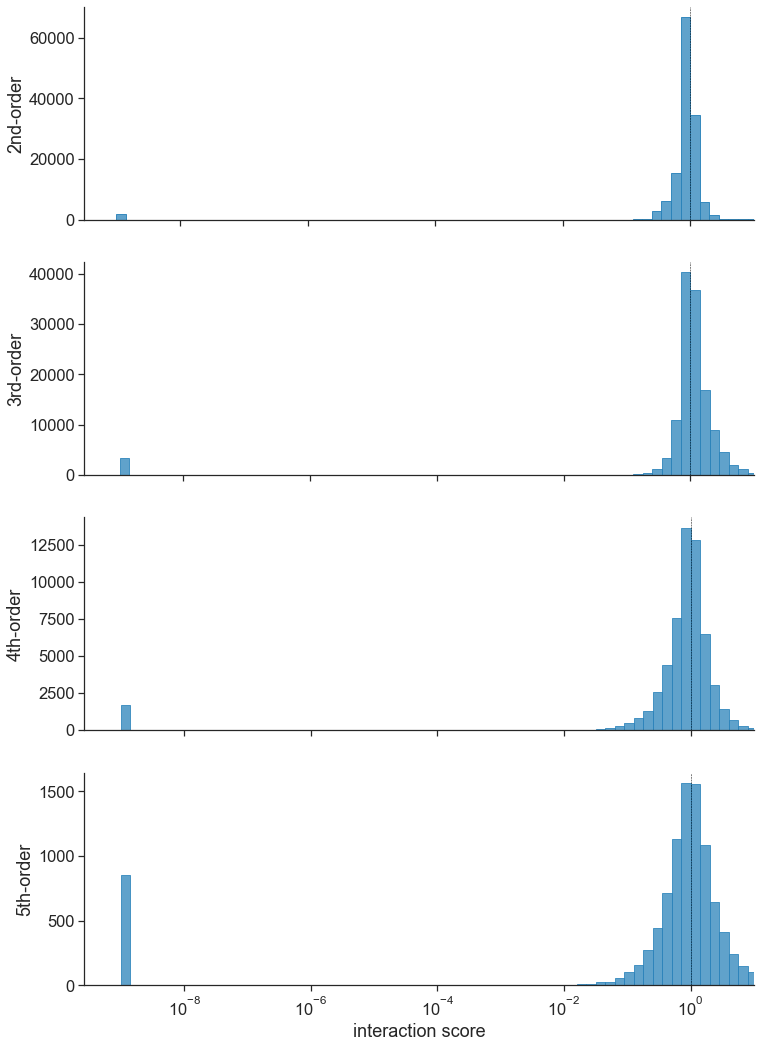

In [ ]:

def get_noninf(df):
    y = np.array(concat_cols(df.filter(regex=(".*_mult"))))
    x = np.array([i+0.000000001 if i == 0 else i for i in y[np.isfinite(y)]])
    return x

def mk_histplot(df, pl, title, row):
    sns.histplot(get_noninf(df), binwidth=pl['binwid'], color=pl['col_mult'], edgecolor=pl['edgecol_mult'], ax=axs[row], log_scale=True)
    if row < 3:
        axs[row].set(xlabel=None, ylabel=title, xticklabels=[])
    else:
        axs[row].set(xlabel="interaction score", ylabel=title)
    axs[row].set_xlim(0,10)
    axs[row].axvline(1, color="black", linestyle="--", linewidth=0.5)

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15,3))
fig.set_size_inches(12, 18)

mk_histplot(df_doub, for_plt, "2nd-order", 0)
mk_histplot(df_trip, for_plt, "3rd-order", 1)
mk_histplot(df_quad, for_plt, "4th-order", 2)
mk_histplot(df_quin, for_plt, "5th-order", 3)


sns.despine()


NOTE: for correlation analyses, there are some duplicate measurements in these data... although they don't have the exact same values across experiments

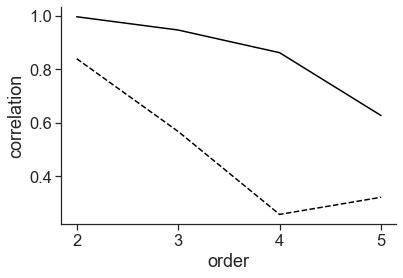

In [ ]:
correlations = []
means = []
medians = []
stds = []
orders = [2,3,4,5]

for i, tmp_df in enumerate([df_doub, df_trip, df_quad, df_quin]):
        d = { "iss" : concat_cols(tmp_df.filter(regex=(".*_iss"))),
                "mult" : concat_cols(tmp_df.filter(regex=(".*_mult"))) }
        tmp = pd.DataFrame.from_dict(d)
        correlations.append( [orders[i], tmp.corr(method="pearson").mult[0], tmp.corr(method="spearman").mult[0]] ) 
        means.append( [orders[i], np.nanmean(tmp.iss), np.nanmean(tmp.mult[np.isfinite(tmp.mult)])] )
        medians.append( [orders[i], np.nanmedian(tmp.iss), np.nanmedian(tmp.mult[np.isfinite(tmp.mult)])] )
        stds.append( [orders[i], np.nanstd(tmp.iss), np.nanstd(tmp.mult[np.isfinite(tmp.mult)])] )

corrs = pd.DataFrame(correlations, columns=["order", "pearson", "spearman"])
means = pd.DataFrame(means, columns=["order", "isserlis", "multiplicative"])
medians = pd.DataFrame(medians, columns=["order", "isserlis", "multiplicative"])
stds = pd.DataFrame(stds, columns=["order", "isserlis", "multiplicative"])


p=sns.lineplot(data=corrs, x="order", y="pearson", color="black", linestyle="--")
p=sns.lineplot(data=corrs, x="order", y="spearman", color="black")
p.set(ylabel="correlation")
sns.despine()


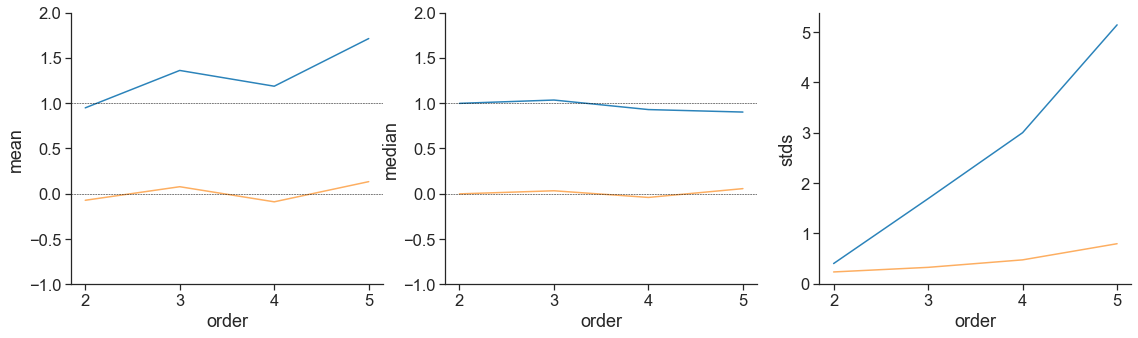

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19,5))

sns.lineplot(data=means, x="order", y="isserlis", color=for_plt['col_iss'], ax=axs[0])
sns.lineplot(data=means, x="order", y="multiplicative", color=for_plt['col_mult'], ax=axs[0])
axs[0].set(ylabel="mean")
axs[0].set_ylim(-1,2)
axs[0].axhline(0, color="black", linestyle="--", linewidth=0.5)
axs[0].axhline(1, color="black", linestyle="--", linewidth=0.5)
sns.lineplot(data=medians, x="order", y="isserlis", color=for_plt['col_iss'], ax=axs[1])
sns.lineplot(data=medians, x="order", y="multiplicative", color=for_plt['col_mult'], ax=axs[1])
axs[1].set(ylabel="median")
axs[1].set_ylim(-1,2)
axs[1].axhline(0, color="black", linestyle="--", linewidth=0.5)
axs[1].axhline(1, color="black", linestyle="--", linewidth=0.5)

sns.lineplot(data=stds, x="order", y="isserlis", color=for_plt['col_iss'], ax=axs[2])
sns.lineplot(data=stds, x="order", y="multiplicative", color=for_plt['col_mult'], ax=axs[2])
axs[2].set(ylabel="stds")
sns.despine()


<ipython-input-12-c84df0f347a3>:23: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  axs[index].pie(d, labels = l, colors = c, autopct='%.0f%%', pctdistance=0.8, textprops={'fontsize': 10})


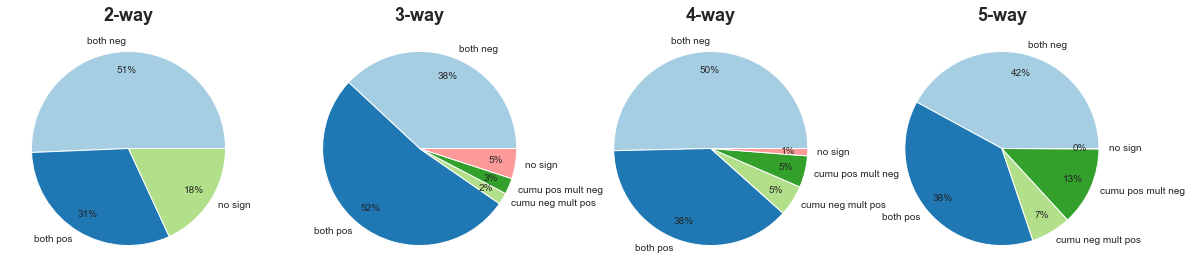

In [ ]:
def compute_sign_switches(df):
    iss = np.array(concat_cols(df.filter(regex=(".*_iss"))))
    mult = np.array(concat_cols(df.filter(regex=(".*_mult"))))
    
    iss = iss[np.isfinite(mult)]
    mult = mult[np.isfinite(mult)]

    results = {}
    results['both pos'] = np.sum((iss > 0) & (mult > 1))
    results['both neg'] = np.sum((iss < 0) & (mult < 1))
    results['cumu pos mult neg'] = np.sum((iss > 0) & (mult < 1))
    results['cumu neg mult pos'] = np.sum((iss < 0) & (mult > 1))
    results['no sign'] = np.sum((iss == 0) | (mult == 1))

    total = np.sum([results[i] for i in sorted(results)])
    data = [results[i]/total for i in sorted(results) if results[i] > 0]
    labels = [i for i in sorted(results) if results[i] > 0]

    return data, labels


def plot_pie(d, l, c, t, index):
    axs[index].pie(d, labels = l, colors = c, autopct='%.0f%%', pctdistance=0.8, textprops={'fontsize': 10})
    axs[index].set_title(t, fontweight="bold")

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,10))
colors = sns.color_palette('Paired')[0:5]

data, labels = compute_sign_switches(df_doub)
plot_pie(data, labels, colors, "2-way", 0)

data, labels = compute_sign_switches(df_trip)
plot_pie(data, labels, colors, "3-way", 1)

data, labels = compute_sign_switches(df_quad)
plot_pie(data, labels, colors, "4-way", 2)

data, labels = compute_sign_switches(df_quin)
plot_pie(data, labels, colors, "5-way", 3)



higher order columns names
Index(['X1X2X3X4', 'X1X2X3X5', 'X1X2X4X5', 'X1X3X4X5', 'X2X3X4X5'], dtype='object')
lower order column names
Index(['X1X2X3', 'X1X2X4', 'X1X2X5', 'X1X3X4', 'X1X3X5', 'X1X4X5', 'X2X3X4',
       'X2X3X5', 'X2X4X5', 'X3X4X5'],
      dtype='object')
higher_order_degree:  4 lower_order_degree:  3
higher order col:  X1X2X3X4 combo of lower order cols:  ['X1X2X3', 'X1X2X4', 'X1X3X4', 'X2X3X4']
higher order col:  X1X2X3X5 combo of lower order cols:  ['X1X2X3', 'X1X2X5', 'X1X3X5', 'X2X3X5']
higher order col:  X1X2X4X5 combo of lower order cols:  ['X1X2X4', 'X1X2X5', 'X1X4X5', 'X2X4X5']
higher order col:  X1X3X4X5 combo of lower order cols:  ['X1X3X4', 'X1X3X5', 'X1X4X5', 'X3X4X5']
higher order col:  X2X3X4X5 combo of lower order cols:  ['X2X3X4', 'X2X3X5', 'X2X4X5', 'X3X4X5']
[ True  True  True ...  True  True  True]
finites:  272160
higher order columns names
Index(['X1X2X3X4', 'X1X2X3X5', 'X1X2X4X5', 'X1X3X4X5', 'X2X3X4X5'], dtype='object')
lower order column names


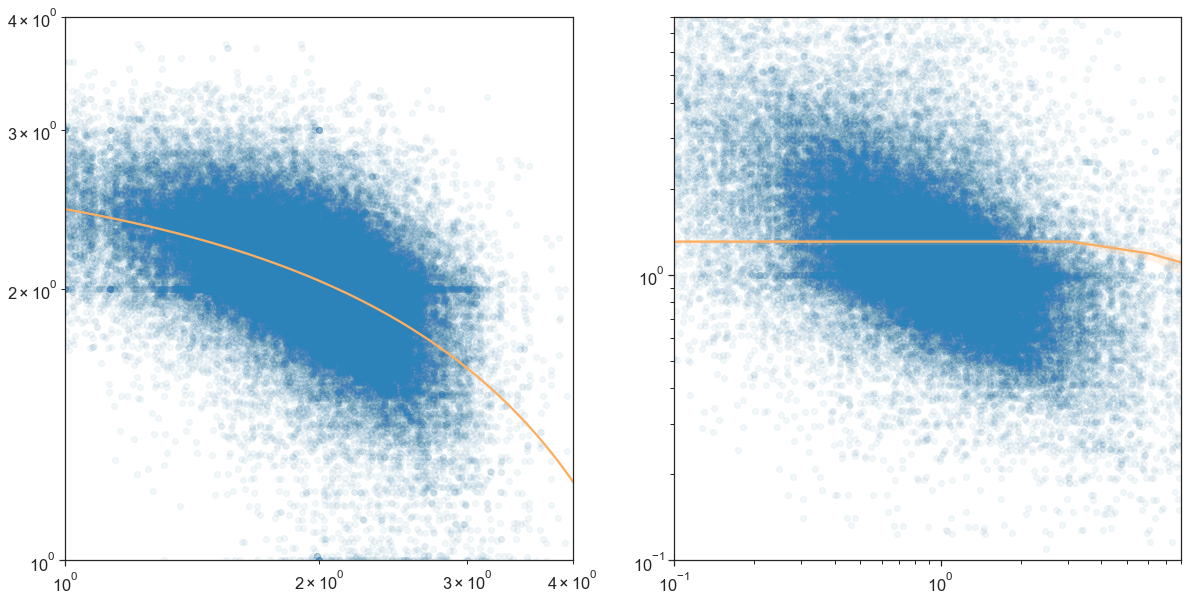

In [ ]:


def func(df_higher_order, df_lower_order, suff):
    df1 = df_higher_order.filter(regex=(f".*{suff}"))
    df2 = df_lower_order.filter(regex=(f".*{suff}"))
    df1.columns = df1.columns.str.rstrip(suff)
    df2.columns = df2.columns.str.rstrip(suff)

    print("higher order columns names")
    print(df1.columns)
    print("lower order column names")
    print(df2.columns)

    higher_order_degree = int(len(df1.columns[0])/2)
    lower_order_degree = int(len(df2.columns[0])/2)
    print("higher_order_degree: ", higher_order_degree, "lower_order_degree: ", lower_order_degree)

    # for each column of higher order interactions, find the lower oreder columns that consist of the lower order combinations
    # each row corresponds to a drug combination, so for each higher order interaction value (x values), find all the lower
    # order interactions (y values) from the same row
    x, y, = np.array([]), np.array([])
    for col in df1.columns:
        Xs = [col[i:i+2] for i in range(0, len(col), 2)]
        lower_order_cols = ["".join(list(i)) for i in list(itertools.combinations(Xs, lower_order_degree))]
        print("higher order col: ", col, "combo of lower order cols: ",  lower_order_cols)
        for i in lower_order_cols:
            x = np.append(x, list(df1[col]))
            y = np.append(y, list(df2[i]))
    
    finites = np.isfinite(y) & np.isfinite(x)
    print(finites)
    print("finites: ", np.sum(finites))
    x = x[finites]
    y = y[finites]
    return x, y

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

x_iss, y_iss = func(df_quad, df_trip, "_iss")
x_mult, y_mult = func(df_quad, df_trip, "_mult")
sns.regplot(x=x_iss+2, 
            y=y_iss+2,   
            scatter_kws={'alpha':0.02, 'color': for_plt['col_mult']},
            line_kws={'color': for_plt['col_iss']},
            ax = axs[0])
axs[0].set_xlim(1,4)
axs[0].set_ylim(1,4)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
sns.regplot(x=x_mult, 
            y=y_mult,   
            scatter_kws={'alpha':0.02, 'color': for_plt['col_mult']},
            line_kws={'color': for_plt['col_iss']},
            ax = axs[1])
axs[1].set_xlim(0.1,8)
axs[1].set_ylim(0.1,8)
axs[1].set_xscale('log')
axs[1].set_yscale('log')


In [ ]:
print(pd.DataFrame(list(zip(x_iss, y_iss)), columns=["x", "y"]).corr(method="pearson"))
print(pd.DataFrame(list(zip(np.log(x_mult), np.log(y_mult))), columns=["x", "y"]).corr(method="pearson"))

          x         y
x  1.000000 -0.595432
y -0.595432  1.000000
          x         y
x  1.000000 -0.545771
y -0.545771  1.000000


<ipython-input-14-46cf5f6e1bec>:2: RuntimeWarning: divide by zero encountered in log
  print(pd.DataFrame(list(zip(np.log(x_mult), np.log(y_mult))), columns=["x", "y"]).corr(method="pearson"))


(-0.1, 7.0)

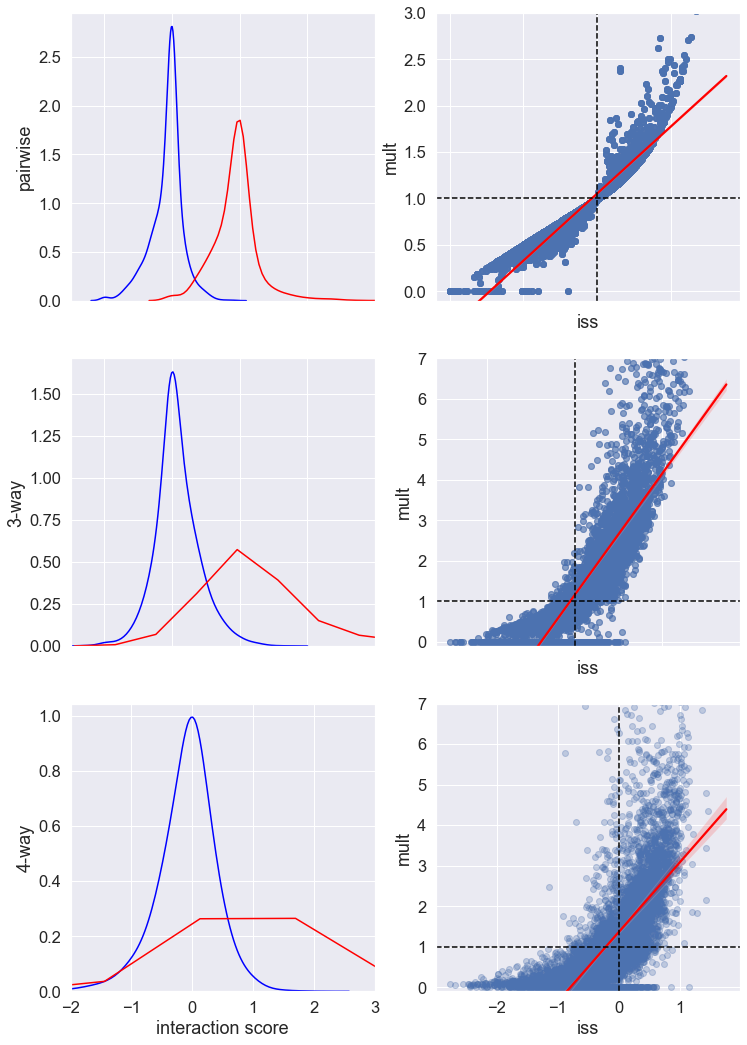

In [ ]:
# KDE plots look like shit


def get_noninf(df):
    x = np.array(concat_cols(df.filter(regex=(".*_iss"))))
    y = np.array(concat_cols(df.filter(regex=(".*_mult"))))
    return x[np.isfinite(y)], y[np.isfinite(y)]

sns.set(font_scale = 1.5)
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15,5))
fig.set_size_inches(12, 18)
bins=20
bw=3
transparency=0.1

##################
sns.kdeplot(concat_cols(df_doub.filter(regex=(".*_iss"))),  color="blue", bw_adjust=bw, ax=axs[0,0])
sns.kdeplot(concat_cols(df_doub.filter(regex=(".*_mult"))),  color="red", bw_adjust=bw, ax=axs[0,0])
axs[0,0].set(xlabel=None, ylabel="pairwise", xticklabels=[])
axs[0,0].set_xlim(-1.5,3)

x, y = get_noninf(df_doub)
sns.regplot(x=x, 
            y=y,   
            scatter_kws={'alpha':transparency},
            line_kws={'color': 'red'},
            ax=axs[0,1])
axs[0,1].set(xlabel="iss", ylabel="mult", xticklabels=[])
axs[0,1].axvline(0, color="black", linestyle="--")
axs[0,1].axhline(1, color="black", linestyle="--")
axs[0,1].set_ylim(-0.1,3)

##################
sns.kdeplot(concat_cols(df_trip.filter(regex=(".*_iss"))),  color="blue", bw_adjust=bw, ax=axs[1,0])
sns.kdeplot(concat_cols(df_trip.filter(regex=(".*_mult"))),  color="red", bw_adjust=bw, ax=axs[1,0])
axs[1,0].set(xlabel=None, ylabel="3-way", xticklabels=[])
axs[1,0].set_xlim(-1.5,3)


x, y = get_noninf(df_trip)
sns.regplot(x=x, 
            y=y,  
            scatter_kws={'alpha':transparency},
            line_kws={'color': 'red'},
            ax=axs[1,1])
axs[1,1].set(xlabel="iss", ylabel="mult", xticklabels=[])
axs[1,1].axvline(0, color="black", linestyle="--")
axs[1,1].axhline(1, color="black", linestyle="--")
axs[1,1].set_ylim(-0.1,7)

##################
sns.kdeplot(concat_cols(df_quad.filter(regex=(".*_iss"))),  color="blue", bw_adjust=bw, ax=axs[2,0])
sns.kdeplot(concat_cols(df_quad.filter(regex=(".*_mult"))),  color="red", bw_adjust=bw, ax=axs[2,0])
axs[2,0].set(xlabel="interaction score", ylabel="4-way")
axs[2,0].set_xlim(-2,3)

x, y = get_noninf(df_quad)
sns.regplot(x=x,
            y=y,  
            scatter_kws={'alpha':transparency},
            line_kws={'color': 'red'},
            ax=axs[2,1])
axs[2,1].set(xlabel="iss", ylabel="mult")
axs[2,1].axvline(0, color="black", linestyle="--")
axs[2,1].axhline(1, color="black", linestyle="--")
axs[2,1].set_ylim(-0.1,7)
